In [1]:
from compare_UTILS import *


# CONVENTIONS on bias
- CUON: we must subtract the bias adjustment found in the adv_homog table from the raw i.e. adj = raw - bias
- RHARM and SUNY: we must subtract adjusted from raw i.e. bias= raw - adjusted

In [2]:
# load data for a list of stations (IGRA, RHARM, CUON< SUNY)
stations = ['USM00070316' , 'USM00070350', 'USM00070308', 'PSM00091408' , 'AUM00011035' , 'GMM00010393' , 'GMM00010739']


# not operation bias stations: test these stations to check if RAOBCORE exists but no ERA5 bias
# no_operational_bias = ['RSM00027707','RSM00027612','RSM00034122', 'RSM00027459', 'CHM00057494', 'CHM00057972','CHM00057447' ]
# stations = stations + no_operational_bias


# loading igra stations list
igrainv=pd.read_fwf('igra2-station-list.txt',widths=(11,10,7,4,30,5,5,7),
                        names=('StationId','Latitude','Longitude','Elev','dummy','StationName','From','To','Nrec'))   
    
all_igra =''

all_stations = [f for f in igrainv.StationId.values if 'ZZ' not in f ] 

In [3]:
# select pressure levels
stdplevs = [ i*100 for i in [10.0, 20.0, 30.0, 50.0, 70.0, 100.0, 150.0, 200.0, 250.0, 300.0, 400.0, 500.0, 700.0, 850.0, 925.0, 1000.0] ]

## Extract RHARM data from local database

In [4]:
source = 'csv'
# stations = ['USM00070316' , 'USM00070350', 'USM00070308', 'PSM00091408' , 'AUM00011035' , 'GMM00010393' , 'GMM00010739']

# read IGRA/RHARM files either from local csv files or downloading from the CDS

# container dictionaries for all the downloaded data in the form of pandas dataframe
all_RHARM = {} 
if source == 'csv':
    d = 'new_data_emanuele_27Sept2022'
    for s in stations:
        print('+++ Extracting RHARM data from csv files for ' , s )
        file = d + '/' + s + '.csv'
        
        if os.path.isfile(file):
            df = get_HARM_IGRA_from_CSV(file)
            df['adj'] = df.air_temperature_rharm - df.air_temperature_igra 

            df = df.rename({'a': 'X', 'b': 'Y'}, axis=1)  # new method
            df['air_temperature'] = df['air_temperature_igra']
            df['report_timestamp'] = pd.to_datetime( df['report_timestamp'] ).dt.tz_localize(None)  ### TO DO to remove the +00 from timestamps , see Cannot compare tz-naive and tz-aware datetime-like objects bug
            #df = df.loc [ (df.report_timestamp >= pd.Timestamp('2009-01-01')  ) & (df.report_timestamp <= pd.Timestamp('2010-12-31') )  ]

            all_RHARM[s] = df 
        else:
            all_RHARM[s] = pd.DataFrame()    
else:
    all_HARM_df, all_IGRA_df, all_HARM_df_test, all_IGRA_df_test = get_RHARM_IGRA_from_CDS(stations)

+++ Extracting RHARM data from csv files for  USM00070316
+++ Extracting RHARM data from csv files for  USM00070350
+++ Extracting RHARM data from csv files for  USM00070308
+++ Extracting RHARM data from csv files for  PSM00091408
+++ Extracting RHARM data from csv files for  AUM00011035
+++ Extracting RHARM data from csv files for  GMM00010393
+++ Extracting RHARM data from csv files for  GMM00010739


## Extract CUON data from local database

In [5]:
#stations = [] 
#stations = ['USM00070316']

stations = stations

# container for the CUON dataframes
all_CUON = {}

for s in stations:
    cuon_csv_data = 'data_CUON'
    saved_csv = glob.glob(cuon_csv_data+'/*'+s[-5:]+'*')
    
    try:
        if len(saved_csv) >0:
            print('+++ Extracting CUON data saved in csv file ' , s )
            df = pd.read_csv(saved_csv[0] , sep='\t') 
            df['date_time'] = pd.to_datetime(df.date_time)

        else:        
            print('+++ Extracting CUON data saved in merged netCDF file for ' , s )
            f = glob.glob(basedir+'/*'+s[-5:]+'*') # get the correct file name in the CUON dataset for the IGRA identifier
            #print('Processing::: ' , f )
            if len(f) ==0:
                print("skipping station: " , s)
                missed_stations.append(s)
            else:  
                df = extract_CUON(f[0])
    except:
        print("SKIP:::: " , s)
        pass
    all_CUON[s] = df 
    
# additional stations with no operational bias adjustments
no_operational_bias = ['27707','27612','34122', '27459', '57494', '57972','57447' ]

for s in no_operational_bias:
    cuon_csv_data = 'data_CUON'
    saved_csv = glob.glob(cuon_csv_data + '/*' + s + '*')
    if len(saved_csv) >0:
        print('+++ Extracting CUON data saved in csv file ' , s )
        df = pd.read_csv(saved_csv[0] , sep='\t') 
    
    else:        
        print('+++ Extracting CUON data saved in merged netCDF file for ' , s )
        f = glob.glob(basedir+'/*' + s + '*')[0] # get the correct file name in the CUON dataset for the IGRA identifier
        #print('Processing::: ' , f )
        df = extract_CUON(f)
    all_CUON[s] = df 


+++ Extracting CUON data saved in csv file  USM00070316
+++ Extracting CUON data saved in csv file  USM00070350
+++ Extracting CUON data saved in csv file  USM00070308
+++ Extracting CUON data saved in csv file  PSM00091408
+++ Extracting CUON data saved in csv file  AUM00011035
+++ Extracting CUON data saved in csv file  GMM00010393
+++ Extracting CUON data saved in csv file  GMM00010739
+++ Extracting CUON data saved in csv file  27707
+++ Extracting CUON data saved in csv file  27612
+++ Extracting CUON data saved in csv file  34122
+++ Extracting CUON data saved in csv file  27459
+++ Extracting CUON data saved in csv file  57494
+++ Extracting CUON data saved in csv file  57972
+++ Extracting CUON data saved in csv file  57447


## Extract SUNY data from local database

In [6]:
all_SUNY = {}
# example: #d = extract_SUNY('/users/staff/leo/fastscratch/SUNY/homo-raw-subdaily-station/AFM00040948.nc') 
stations = stations
for s in stations:
    
    suny_csv_files = glob.glob('data_SUNY/*'+s+'*')

    if len(suny_csv_files) >0:
        print('+++ Extracting SUNY data from saved csv file for ' , s )
        df = pd.read_csv(suny_csv_files[0] , sep='\t') 
        df['date_time'] = pd.to_datetime(df.date_time)
        df = df.loc[df["air_temperature"] >= -300 ]
        df = df.loc[df["air_temperature_adj"] >= -300 ]
    else:        
        print('+++ Extracting SUNY data from netCDF file for ' , s )
        f = glob.glob(suny_dir+'/*'+s+'*') # get the correct file name in the CUON dataset for the IGRA identifier
        try:
            print('Processing::: ' , f[0] )
            df = extract_SUNY(f[0])
        except:
            print('Cannot extract: ' , s, ' ', f)
    all_SUNY[s] = df 
    

+++ Extracting SUNY data from saved csv file for  USM00070316
+++ Extracting SUNY data from saved csv file for  USM00070350
+++ Extracting SUNY data from saved csv file for  USM00070308
+++ Extracting SUNY data from saved csv file for  PSM00091408
+++ Extracting SUNY data from saved csv file for  AUM00011035
+++ Extracting SUNY data from saved csv file for  GMM00010393
+++ Extracting SUNY data from saved csv file for  GMM00010739


![pic](pic.png)

I attach one two-panel plot for each of them. In the top plot there is the 12GMT-00GMT difference calculated for each pair of sondes available in the same day at each station. Average statistics are also reported for the entire period (2009-2010) along the x-axis.

In the bottom panel, I report the adjustments applied in the same period. You may notice that the latter may appear as black rectangles sometime, but this is due to the fact that we have constant but different adjustments for night and day.

As you can see for one station (70350) no adjustment are applied in the 2009-2010 (actually should be related to RS80 sondes and this goes back to other examples shown in my talk in Rome).

However, I investigate also the entire time series, I found the applied adjustment quite coherent with the RHARM/IGRA metadata.

As you can see the 12GMT-00GMT differences averaged over the entire time series are around zero. Actually with almost constant adjustments, by subtracting monthly means for day and night we should have small residual. To clarify: did you calculate monthly means for day and night over the entire time series or just for the 2009-2010 as I did?


In [7]:
# select pressure level
p = 10000

In [22]:
def make_timeseries(data, station, p, source='csv', what='data', time='day', skim=20):
    """ Plots timeseries of what = ['data' , 'uncertainty']
    as specified by what - if nothing is given then uncertainty is assumed
    
    time: ['night' , 'day' ] for all selecting the time of the observation (nothing == all)
    
    N.B. it assumes data for all dataset is available
    
    """
    
    # restrict time stamps for data
    for ds in ['CUON','IGRA','RHARM','SUNY']:
        df = data[ds]['df'] 
        try:
            data[ds]['df'] =  df.loc[ df.date_time > pd.Timestamp('19780101') ] 
        except:
            data[ds]['df'] =  df.loc[ df.report_timestamp > pd.Timestamp('19780101') ] 


    ### process data from dataframe 
    c,i,h,s =  data["CUON"]['df'] , data["IGRA"]['df'] , data["RHARM"]['df'] , data["SUNY"]['df']
    i['date_time'] = i['report_timestamp']
    h['date_time'] = h['report_timestamp']
    

    # extract df ready with adjustments
    cuon_adj,suny_adj, igra_adj, rharm_adj = calculate_day_night_adjustment(data=data, 
                                                                            time=time, 
                                                                            source=source)
    # Size of Plots 
    W, H = 1800,1000 

    
    ######################  filter SUNY outliers in the adjustm.
    suny_adj['adj'] =  suny_adj.air_temperature - suny_adj.air_temperature_adj 
    suny_adj = suny_adj.loc[ (suny_adj.adj > -10) & (suny_adj.adj < 10) ]

    
    if what == 'data':  ## plot raw temperature series 
        if source == 'csv':
            temp_h, temp_i = i.air_temperature_rharm, i.air_temperature_igra
            i['temp_igra'] = i.air_temperature_igra
            i['temp_rharm'] = i.air_temperature_rharm
            
        else:
            temp_h, temp_i = h.air_temperature, i.air_temperature
            i['temp'] = i.air_temperature
            h['temp'] = h.air_temperature
        c['observation_value_adj'] = c.observation_value - c.RAOBCORE_bias_estimate

        
        var = ['temp_igra','temp_rharm','observation_value','observation_value_adj','air_temperature','air_temperature_adj']
        df = [i,i,c,c,s,s]
        colors = ['blue', 'cyan', 'orange', 'yellow', 'green', 'lime']
        names = ['IGRA', 'RHARM', 'CUON', 'CUON RAOBCORE', 'SUNY', "SUNY Homog."]
        
        
        fig = go.Figure()
        for n,dd,c,v in zip (names, df, colors, var):
            fig.add_trace(go.Scatter(x= dd.date_time[::skim], y= dd[v][::skim], name= n,  line=dict(width=2,color=c)), )

        
        """
        ### Temperature raw data 
        fig.add_trace(go.Scatter(x= i.date_time, y= temp_i, name= 'IGRA',  line=dict(width=2,color='blue')), )
        
        fig.add_trace(go.Scatter(x= h.date_time, y= temp_h, name= 'RHARM', line=dict(width=2,color='cyan')), )
        
        fig.add_trace(go.Scatter(x= c.date_time, y= c.observation_value, name= 'CUON', line=dict(width=2,color='orange')), )
        
        fig.add_trace(go.Scatter(x= c.date_time, y= c.observation_value + c.RAOBCORE_bias_estimate, name= 'CUON RAOBCORE', line=dict(width=2,color='yellow')), )
            
        fig.add_trace(go.Scatter(x= s.date_time, y= s.air_temperature, name= 'SUNY', line=dict(width=2,color='green')),  )
        
        fig.add_trace(go.Scatter(x= s.date_time, y= s.air_temperature_adj, name= 'SUNY Homog.', line=dict(width=2,color='lime')), )       
        """
        
        ### Properties
        fig.update_layout(title_text='Temperature Time Series for ' + station + ' at p=' + str(p) + ' [Pa]',
                           xaxis_title='',
                           yaxis_title='Temp [K]',
                           autosize=False,
            width=W,
            height=H,)

     ### DAY-NIGHT difference
        fig2 = go.Figure()

        # data["SUNY"]['daynight'] = [s_date, s_tempdiff_raw, s_tempdiff_adj] ### structure of data
        
        """
        fig2.add_trace(go.Scatter(x=data["IGRA"]['daynight'][0], y= data["IGRA"]['daynight'][1] , name= 'IGRA',
                                             line=dict(width=2,color='blue')),
        )
        fig2.add_trace(go.Scatter(x=data["RHARM"]['daynight'][0], y= data["RHARM"]['daynight'][2], name= 'RHARM',
                                             line=dict(width=2,color='cyan')),
        )
        ... etc ...
        """
        
        
        names = ['IGRA','RHARM','CUON','CUON RAOBCORE','SUNY','SUNY Homog.']
        ds = ['IGRA','RHARM','CUON','CUON','SUNY','SUNY']
        colors = ['blue', 'cyan', 'orange', 'yellow', 'green', 'lime']
        index = [1,2,1,2,1,2]
        
        for n,d,c,i in zip (names, ds, colors, index):
            fig2.add_trace(go.Scatter(x=data[d]['daynight'][0][::skim], y= data[d]['daynight'][i][::skim], name= n,
                                             line=dict(width=2, color=c)),
        )   

        fig2.update_layout(title_text='Temperature Day-Night 12GMT-00GMT for ' + station + ' at p=' + str(p) + ' [Pa]',
                           xaxis_title='',
                           yaxis_title='Temp [K]',
                           autosize=False,
            width=W,
            height=H,
                         )

    else:  ## plot adjustments

        fig = go.Figure()

        ### Adjustment  
        fig.add_trace(go.Scatter(x=rharm_adj.report_timestamp[::skim], y= rharm_adj.adj[::skim], name= 'RHARM Adjust.',
                                             line=dict(width=2,color='cyan')), )
        
        #if not source == 'csv':
        #    fig.add_trace(go.Scatter(x=adj_test.report_timestamp, y= adj_test.adj, name= 'RHARM CDS-TEST Adjust.',
        #                                         line=dict(width=2,color='green')),
        #    )
        
        cuon_adj['ERA5_bias'] = cuon_adj['biascorr@body']
        for a,col in zip( ['RAOBCORE_bias_estimate', 'RASE_bias_estimate', 'RICH_bias_estimate', 'RISE_bias_estimate', 'ERA5_bias'],
                      ['navy','blue','slateblue','teal', 'magenta'] ):
                fig.add_trace(go.Scatter(x=cuon_adj.date_time[::skim], y= cuon_adj[a][::skim], name= a,
                                             line=dict(width=2,color=col)),
        )


        fig.add_trace(go.Scatter( x=suny_adj.date_time[::skim], y= suny_adj.adj[::skim] , name= 'SUNY Adjust.', line=dict(width=2,color='lime')), )
        
        fig.update_layout(title_text='Temperature Adjustments Series for ' + station + ' at p=' + str(p) + ' [Pa] - ' + time + ' Time'  ,
                           xaxis_title='',
                           yaxis_title='Temp [K]',
                           autosize=False,
            width=W,
            height=H,
                         )
        ### Histogram, not necessary
        fig2 = go.Figure()
        #fig2.add_trace( go.Histogram(x=adj_test.adj, name = 'RHARM Adj.'), )
        #fig2.update_layout(title_text='Adjustments Histogram for ' + station + ' at p=' + str(p) + ' [Pa]',
        #                   xaxis_title='',
        #                   yaxis_title='Temp [K]',
        #                   autosize=False, width=W, height=H, )
            
            
    return fig, fig2

![pic](70308.png)

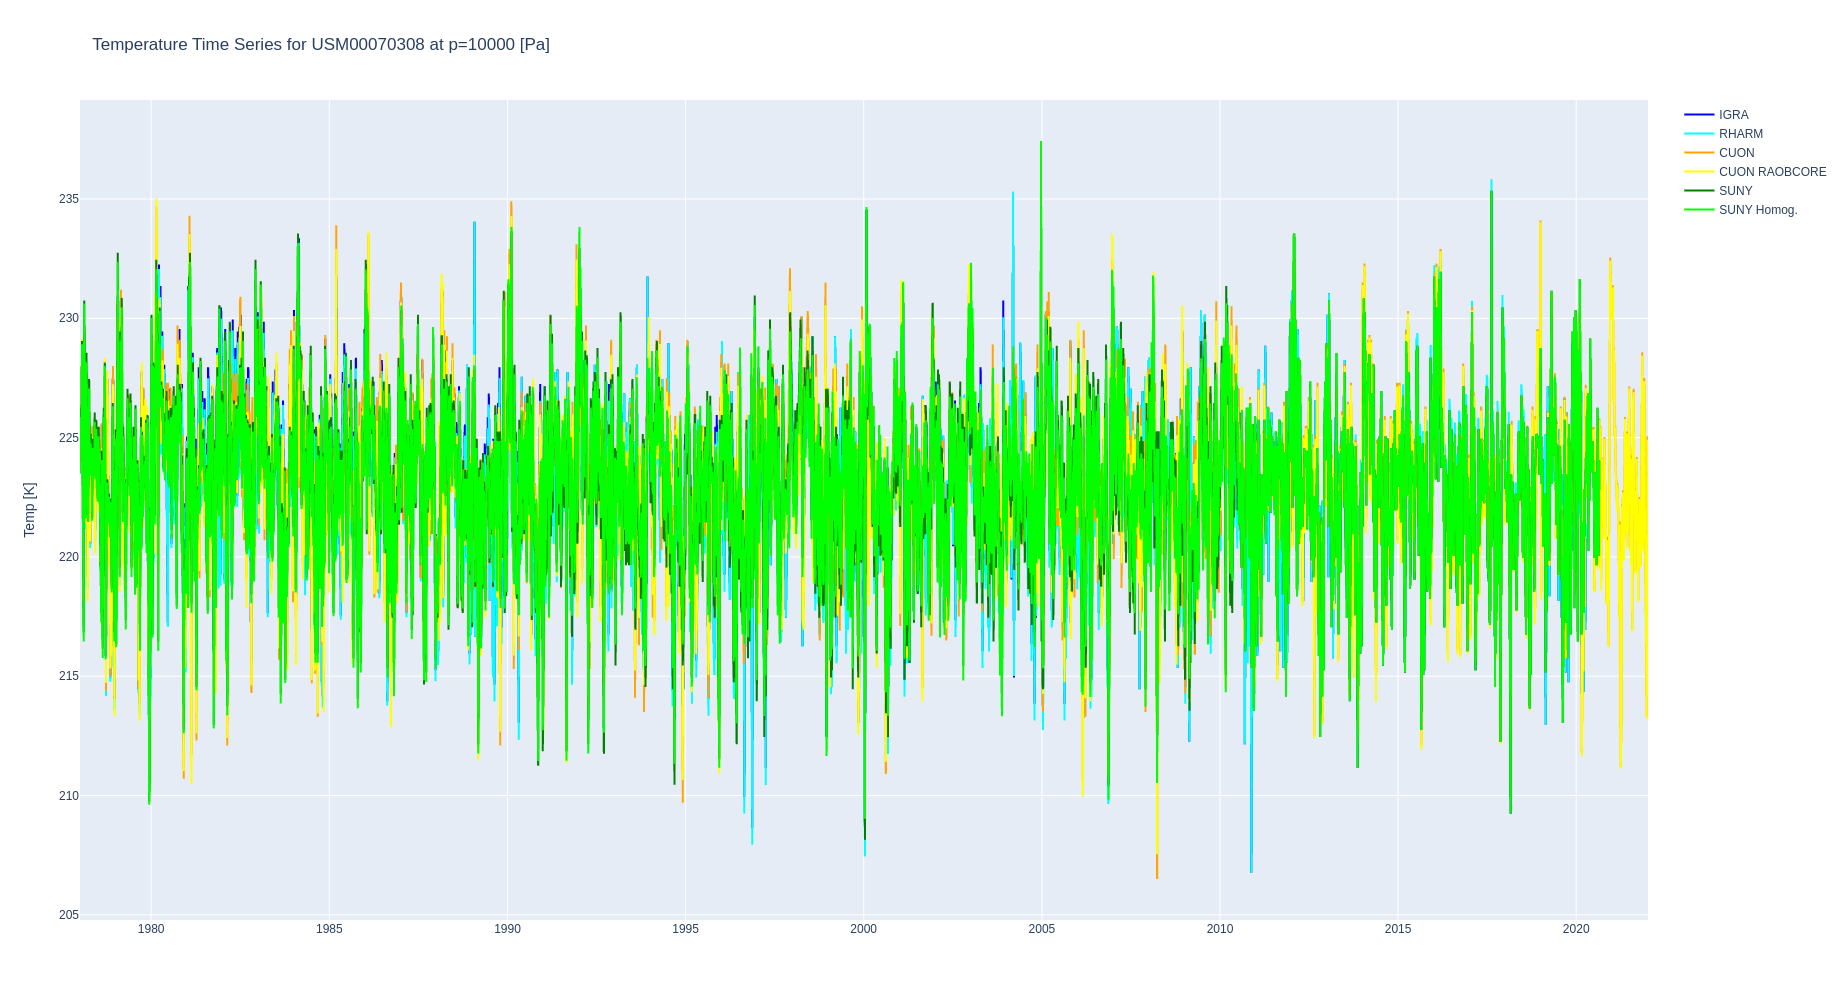

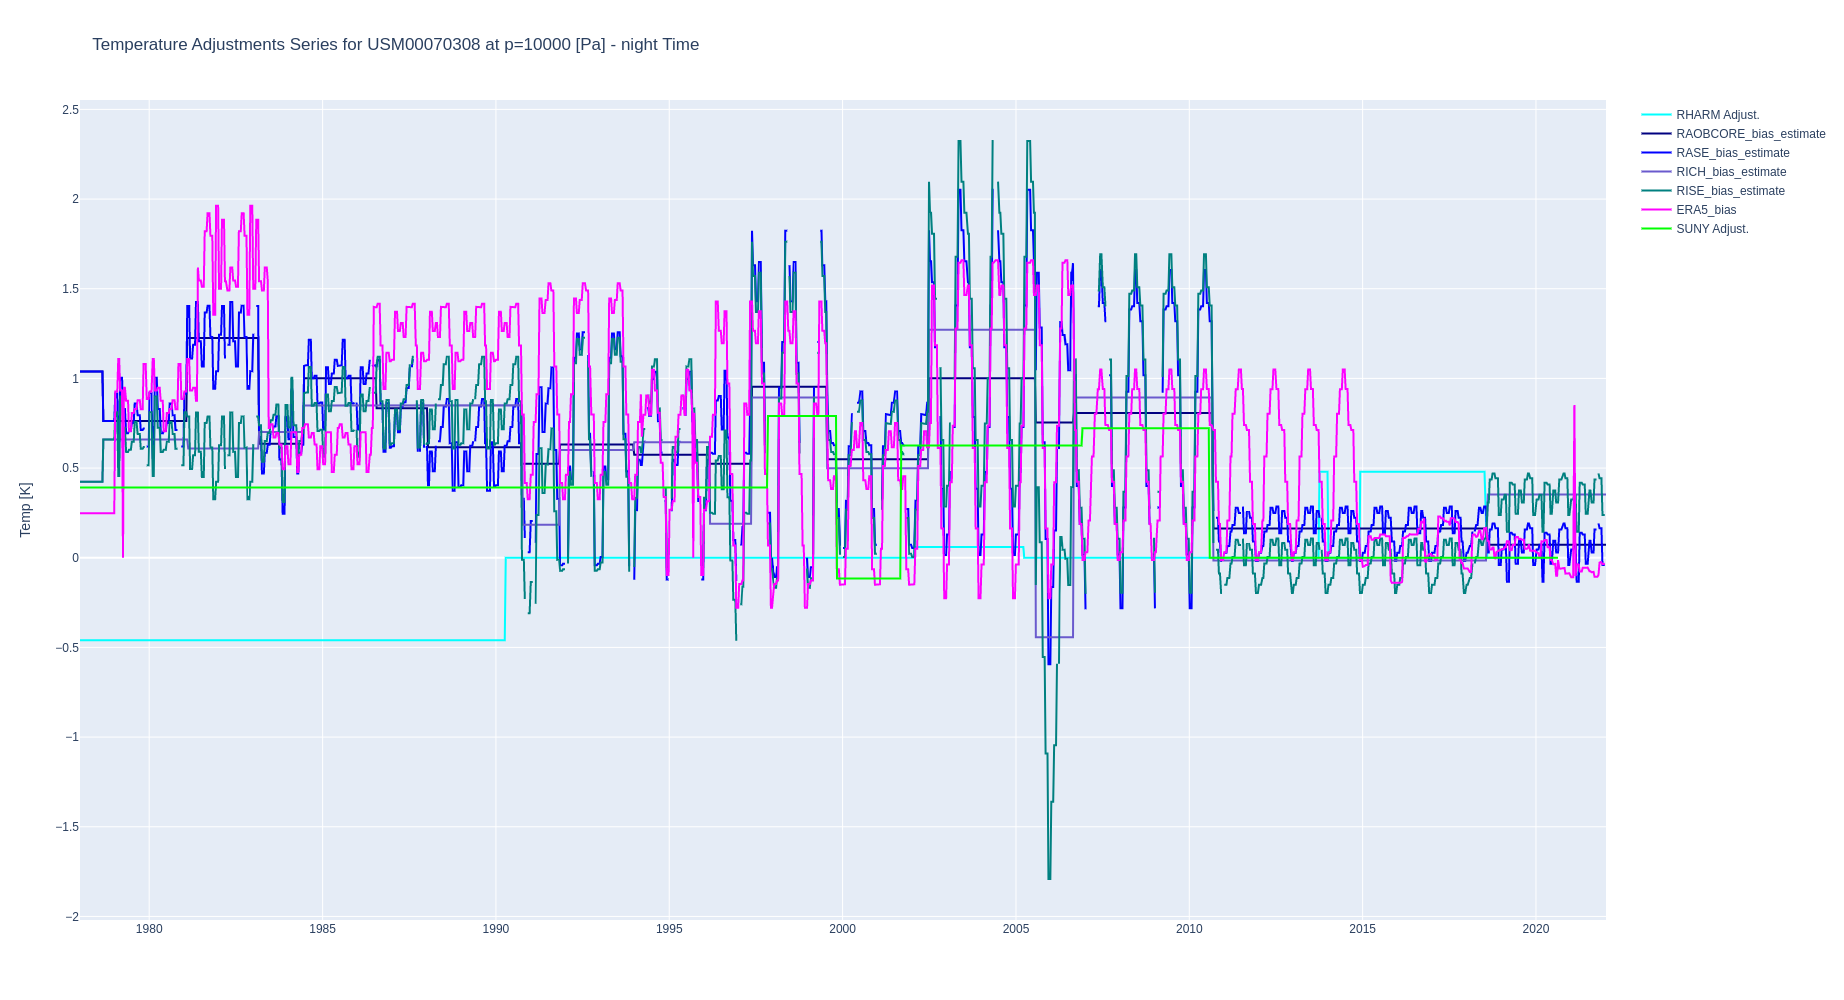

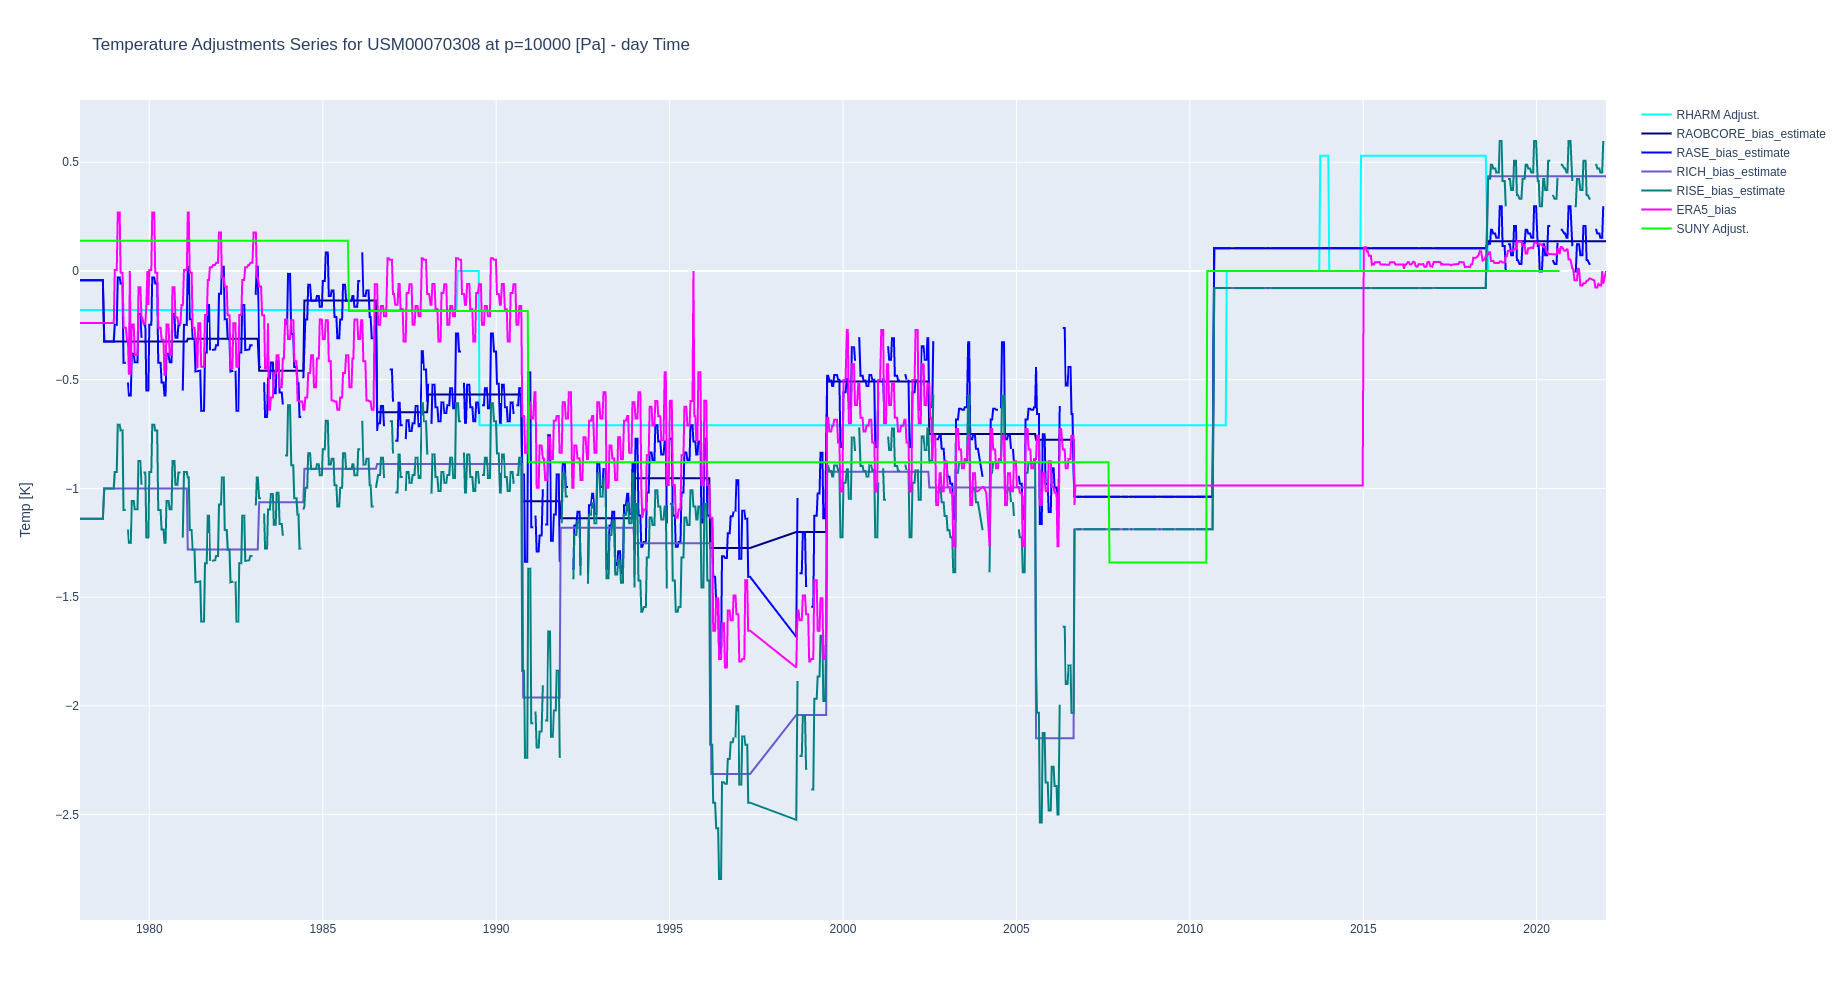

In [23]:
station, p = 'USM00070308' , 10000 
data = extract_data_from_df(station,  all_RHARM, all_CUON, all_SUNY, p, source='csv')

f,g = make_timeseries(data, station, p , skim=10)
f.show()
#g.show()
f,g = make_timeseries(data, station, p, source='csv', what='adj', time='night', skim=10)
f.show()
#g.show()

f,g = make_timeseries(data, station, p, source='csv', what='adj', time='day', skim=10)
f.show()
#g.show()

![pic](70316.png)

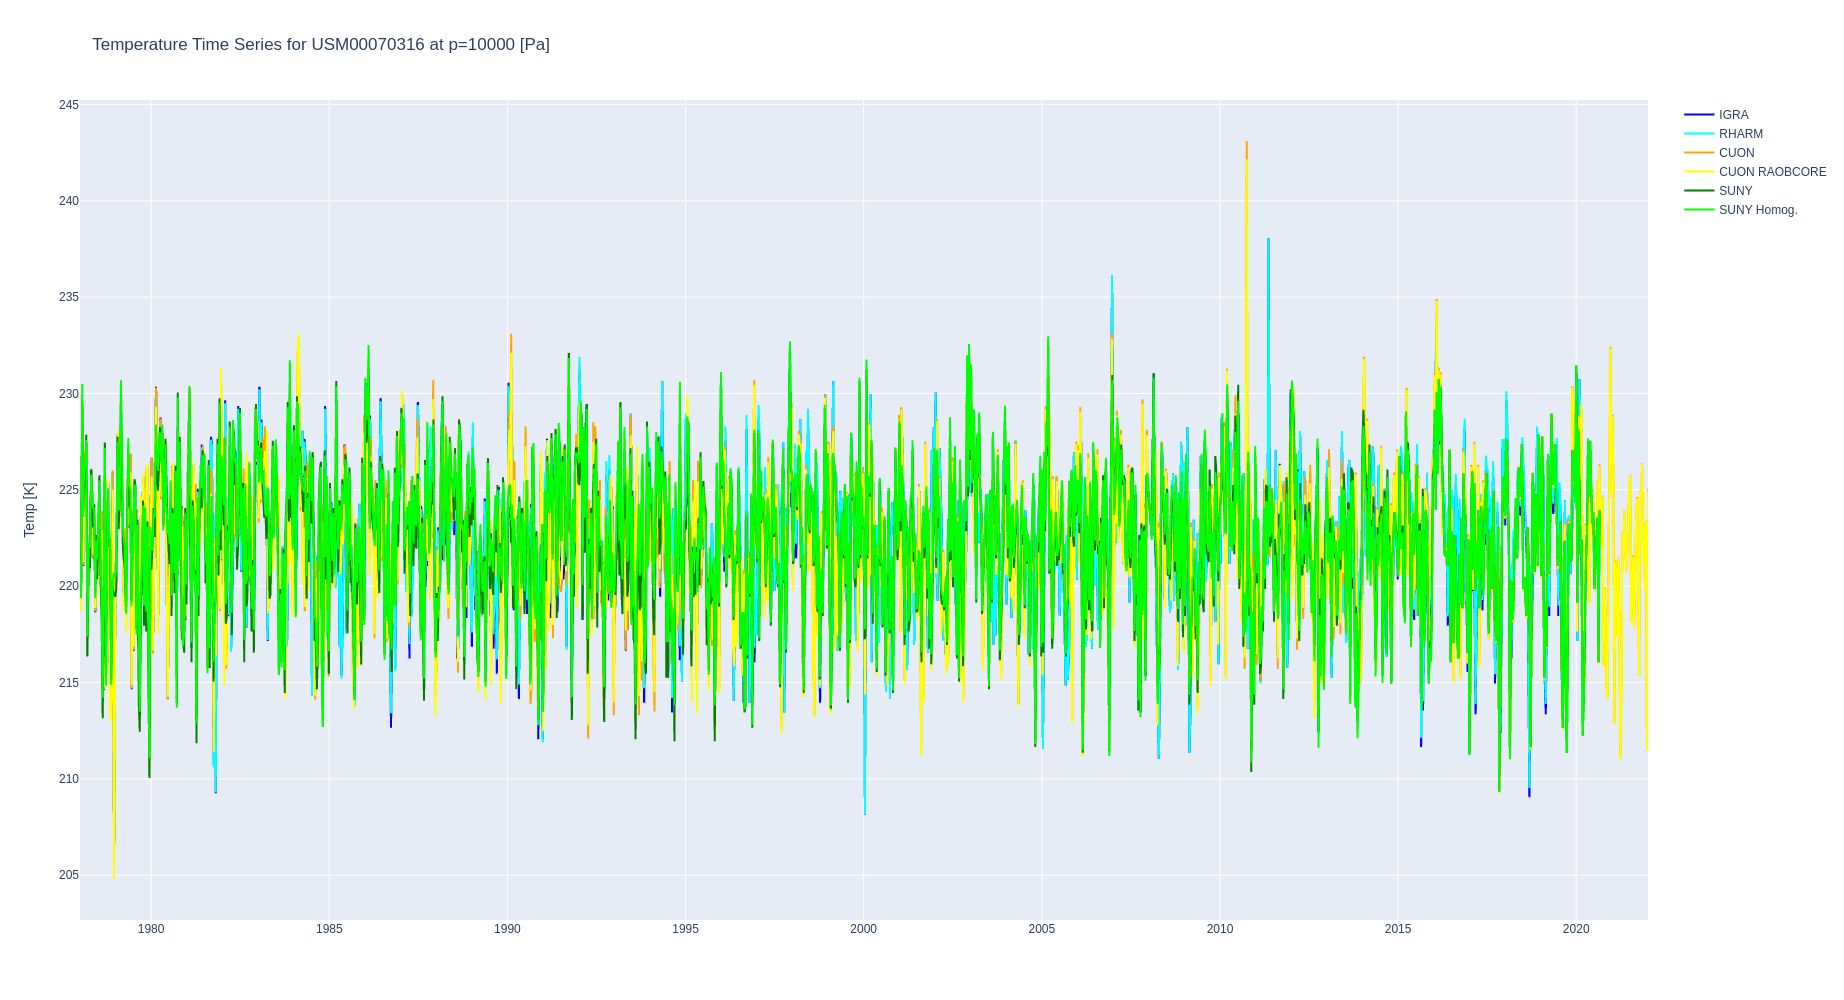

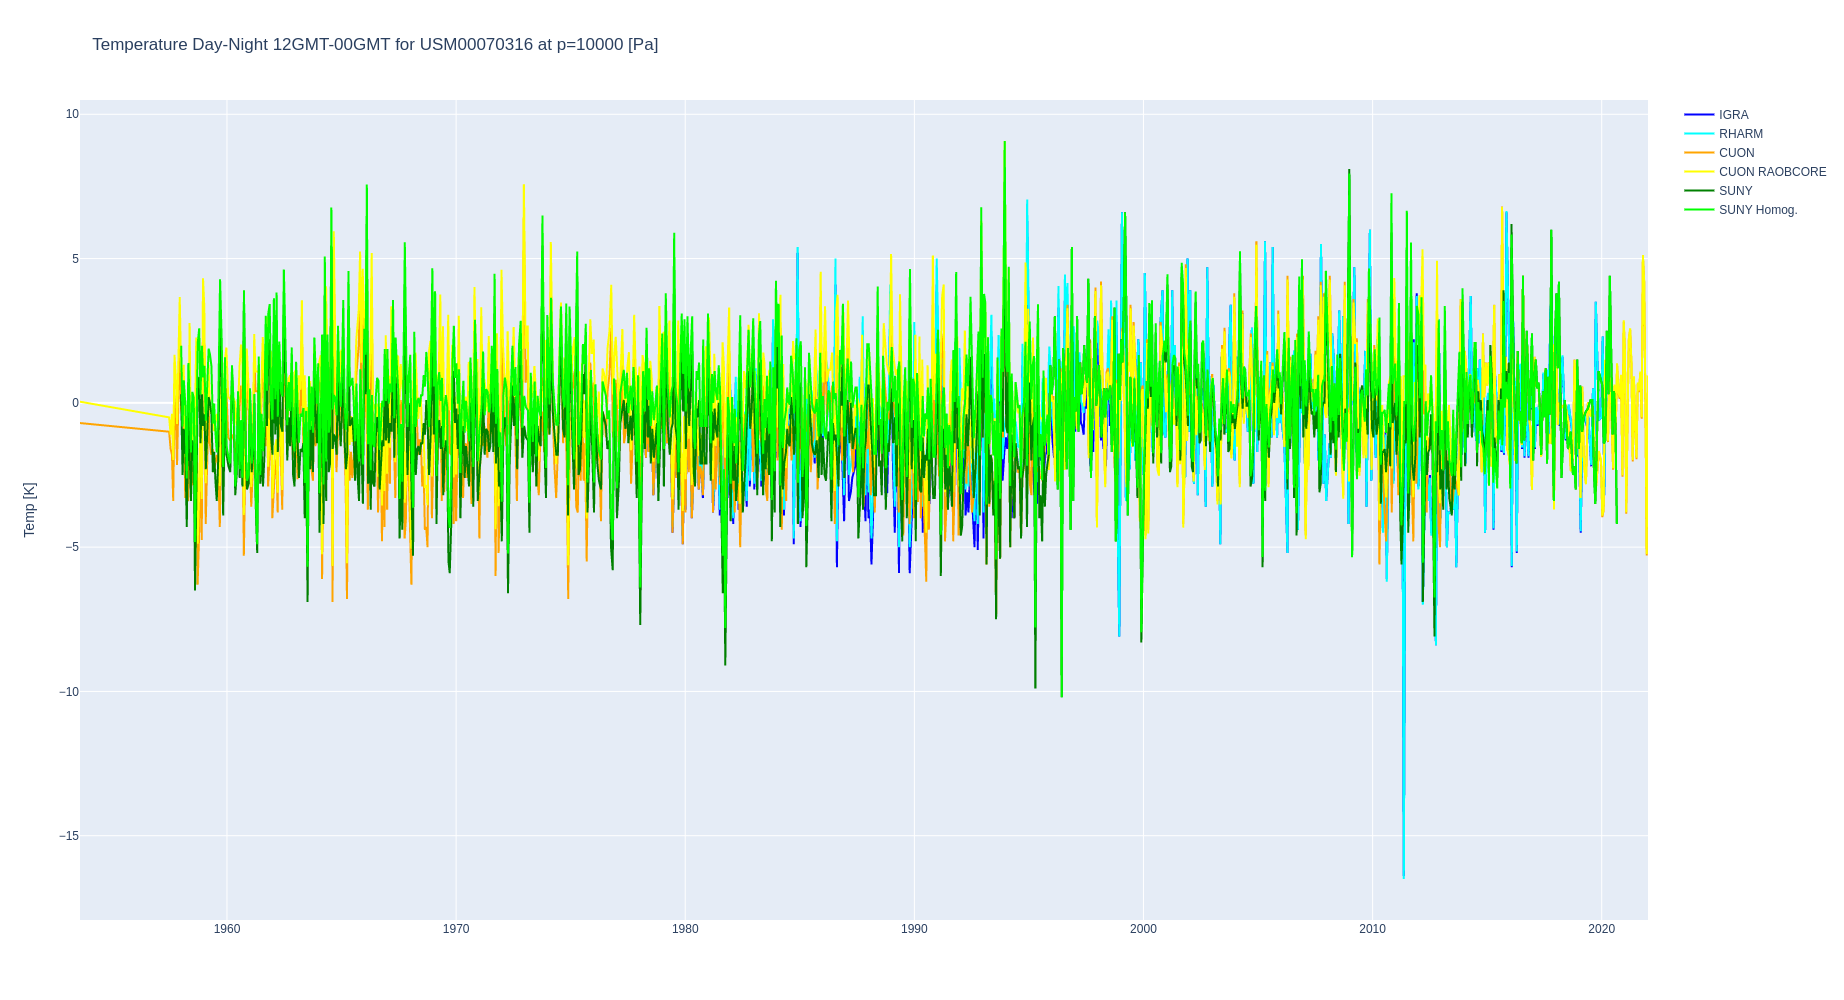

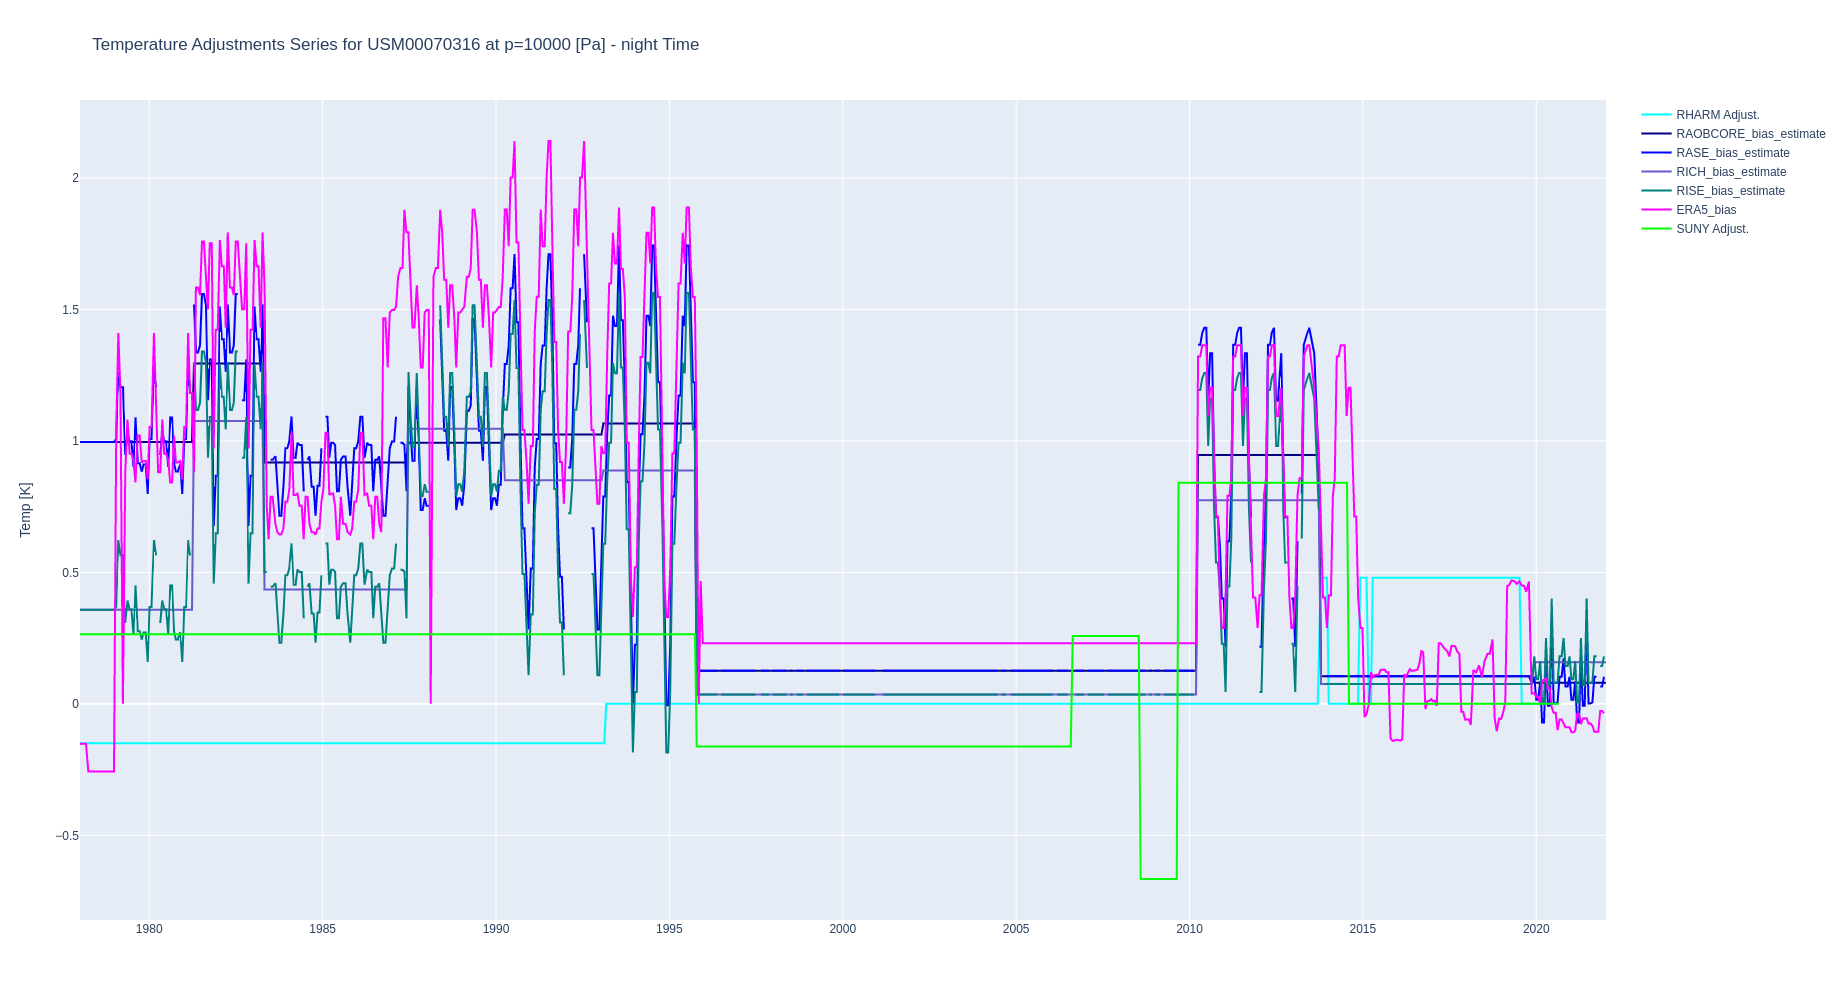

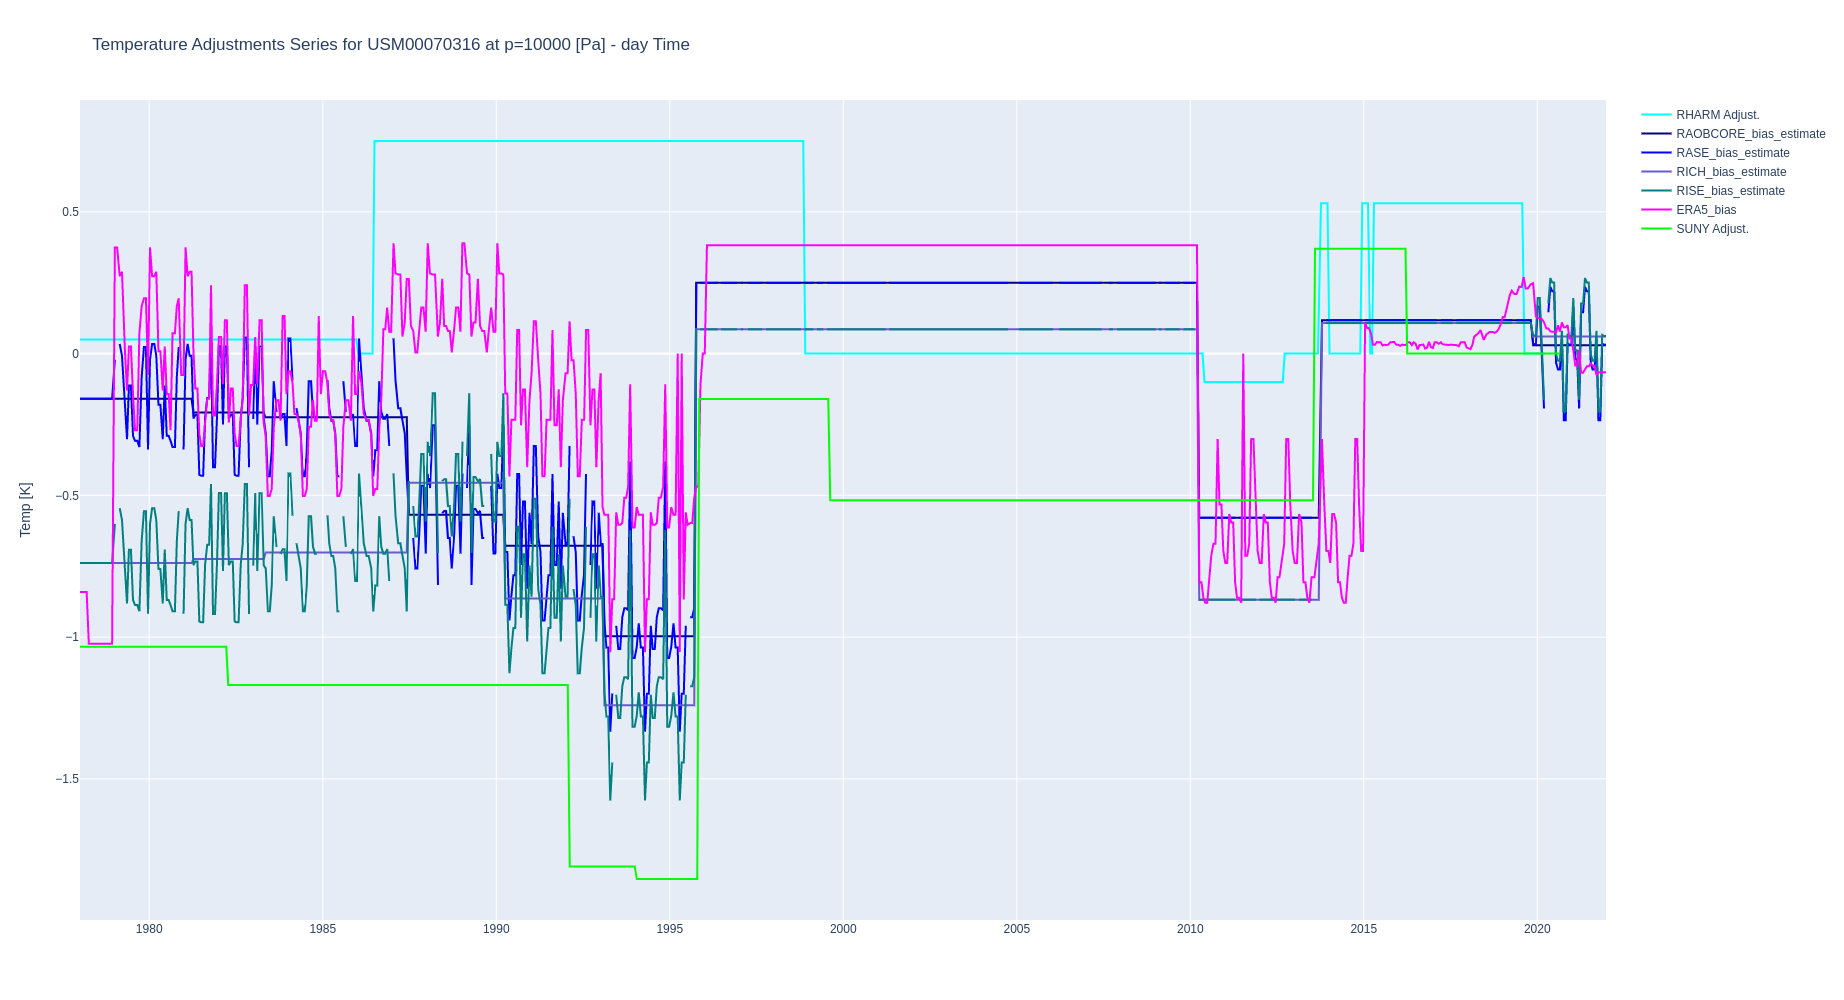

In [24]:

station, p = 'USM00070316' , 10000 
data = extract_data_from_df(station,  all_RHARM, all_CUON, all_SUNY, p, source='csv')
f,g = make_timeseries(data, station, p)
f.show()
g.show()
f,g = make_timeseries(data, station, p, source='csv', what='adj', time='night')
f.show()
#g.show()


f,g = make_timeseries(data, station, p, source='csv', what='adj', time='day')
f.show()
#g.show()


![pic](70350.png)

In [11]:
"""
station, p = 'USM00070350' , 10000 
data = extract_data_from_df(station,  all_RHARM, all_CUON, all_SUNY, p, source='csv')

f,g = make_timeseries(data, station, p)
f.show()
g.show()
f,g = make_timeseries(data, station, p, source='csv', what='adj', time='night')
f.show()
#g.show()


f,g = make_timeseries(data, station, p, source='csv', what='adj', time='day')
f.show()
#g.show()
"""

"\nstation, p = 'USM00070350' , 10000 \ndata = extract_data_from_df(station,  all_RHARM, all_CUON, all_SUNY, p, source='csv')\n\nf,g = make_timeseries(data, station, p)\nf.show()\ng.show()\nf,g = make_timeseries(data, station, p, source='csv', what='adj', time='night')\nf.show()\n#g.show()\n\n\nf,g = make_timeseries(data, station, p, source='csv', what='adj', time='day')\nf.show()\n#g.show()\n"

![pic](91408.png)

In [12]:
station, p = 'PSM00091408' , 10000 
f,g = make_timeseries(data, station, p)
f.show()
g.show()
f,g = make_timeseries(data, station, p, source='csv', what='adj', time='night')
f.show()
#g.show()


f,g = make_timeseries(data, station, p, source='csv', what='adj', time='day')
f.show()
#g.show()


"\nstation, p = 'PSM00091408' , 10000 \nf,g = make_timeseries(data, station, p)\nf.show()\ng.show()\nf,g = make_timeseries(data, station, p, source='csv', what='adj', time='night')\nf.show()\n#g.show()\n\n\nf,g = make_timeseries(data, station, p, source='csv', what='adj', time='day')\nf.show()\n#g.show()\n"

In [13]:
station, p = 'AUM00011035' , 10000 
f,g = make_timeseries(data, station, p)
f.show()
g.show()
f,g = make_timeseries(data, station, p, source='csv', what='adj', time='night')
f.show()
#g.show()


f,g = make_timeseries(data, station, p, source='csv', what='adj', time='day')
f.show()
#g.show()


"\nstation, p = 'AUM00011035' , 10000 \nf,g = make_timeseries(data, station, p)\nf.show()\ng.show()\nf,g = make_timeseries(data, station, p, source='csv', what='adj', time='night')\nf.show()\n#g.show()\n\n\nf,g = make_timeseries(data, station, p, source='csv', what='adj', time='day')\nf.show()\n#g.show()\n"

In [14]:
station, p = 'GMM00010393' , 10000 
f,g = make_timeseries(data, station, p)
f.show()
g.show()
f,g = make_timeseries(data, station, p, source='csv', what='adj', time='night')
f.show()
#g.show()


f,g = make_timeseries(data, station, p, source='csv', what='adj', time='day')
f.show()
#g.show()

"\nstation, p = 'GMM00010393' , 10000 \nf,g = make_timeseries(data, station, p)\nf.show()\ng.show()\nf,g = make_timeseries(data, station, p, source='csv', what='adj', time='night')\nf.show()\n#g.show()\n\n\nf,g = make_timeseries(data, station, p, source='csv', what='adj', time='day')\nf.show()\n#g.show()\n"

In [15]:
station, p = 'GMM00010739' , 10000 
f,g = make_timeseries(data, station, p)
f.show()
g.show()
f,g = make_timeseries(data, station, p, source='csv', what='adj', time='night')
f.show()
#g.show()


f,g = make_timeseries(data, station, p, source='csv', what='adj', time='day')
f.show()
#g.show()


"\nstation, p = 'GMM00010739' , 10000 \nf,g = make_timeseries(data, station, p)\nf.show()\ng.show()\nf,g = make_timeseries(data, station, p, source='csv', what='adj', time='night')\nf.show()\n#g.show()\n\n\nf,g = make_timeseries(data, station, p, source='csv', what='adj', time='day')\nf.show()\n#g.show()\n"